In [67]:
import numpy as np
import matplotlib.pyplot as plt
# import pandas_datareader as web
import math
import yfinance as yf
import pandas as pd
import seaborn as sns

# Lecture des informations finance depuis Yahoo

In [68]:
etf = ['BZ=F','EURUSD=X','TTF=F','TTFX23.NYM','TTFZ23.NYM','TTFV23.NYM']
#data = yf.Ticker(etf)
#dataH = data.history(start='2007-01-01',period='1d')
it = yf.download(tickers=etf, period='1d',start='2012-01-01')
it = it.rename(columns = {'TTFU23.NYM':'SEP23', 'TTFX23.NYM':'NOV23','TTFV23.NYM':'OCT23', 'TTFZ23.NYM':'DEC23', 'EURUSD=X':'€/$'})

[*********************100%***********************]  6 of 6 completed


# Lecture des informations de stock de Gaz depuis AGSI
* normalisation des données
* conversion en float
* conversion des dates

pour un Pays remplacer "type" par "country" et mettre en paramètre le code du pays : FR, BE, DE ...

In [69]:
import requests
params = {
    "type": "EU",
    "from": "2012-01-01",
    "size": 10000
}
header = {
  "x-key" : "99e18f932d22c9acf9c42f27d0b8b539" }

url = "https://agsi.gie.eu/api"
resp = requests.get(url=url, params=params, headers=header)
json = resp.json()
data = pd.json_normalize(json['data'])
data["gasInStorage"] = data["gasInStorage"].astype(float)
#data["coveredCapacity"] = data["coveredCapacity"].astype(float)
pd.to_datetime(data['gasDayStart'], errors='coerce')
#data[["gasDayStart","gasInStorage"]]
#print(data)
print('Done')

Done


### Préparation des données (en mois / années)

In [70]:
import datetime as dt
endData = data[["gasDayStart","gasInStorage"]].copy(deep = True)
endData['Date'] = pd.to_datetime(endData['gasDayStart'],format='%Y-%m-%d', errors='coerce',utc=False)
endData['année'] = endData['Date'].dt.year
endData['mois'] = endData['Date'].dt.month
endData.set_index('Date')

,gasDayStart,gasInStorage,année,mois
Date,,,,
2023-09-13,2023-09-13,1068.5602,2023,9
2023-09-12,2023-09-12,1068.5436,2023,9
2023-09-11,2023-09-11,1068.4668,2023,9
2023-09-10,2023-09-10,1068.0645,2023,9
2023-09-09,2023-09-09,1066.8081,2023,9
...,...,...,...,...
2012-01-05,2012-01-05,547.8834,2012,1
2012-01-04,2012-01-04,550.0136,2012,1
2012-01-03,2012-01-03,552.2452,2012,1


In [71]:
def filtreAnnee(df, a):
    mask_ = (df['année'] == a)
    #mask_ = ((fin['mois'] == 2) & (fin['year'] == 2022))
    return df.loc[mask_]

              gasInStorage     TTF=F      BZ=F     OCT23     NOV23     DEC23
gasInStorage      1.000000 -0.152581  0.382718 -0.229183 -0.142494 -0.044086
TTF=F            -0.152581  1.000000  0.294860  0.984626  0.962570  0.938037
BZ=F              0.382718  0.294860  1.000000  0.199049  0.206641  0.239911
OCT23            -0.229183  0.984626  0.199049  1.000000  0.985548  0.958934
NOV23            -0.142494  0.962570  0.206641  0.985548  1.000000  0.991815
DEC23            -0.044086  0.938037  0.239911  0.958934  0.991815  1.000000


<AxesSubplot:>

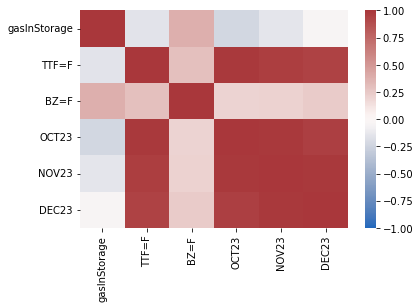

In [74]:
final = pd.merge(endData, it['Close'], how='left', on="Date" )
fin =final.dropna()
# mask_ = (fin['année'] == 2023)
# #mask_ = ((fin['mois'] == 2) & (fin['year'] == 2022))
# fin_ = fin.loc[mask_]
fin_ = filtreAnnee(fin, 2023)
fin_ = (fin_[["gasInStorage","TTF=F","BZ=F","OCT23","NOV23","DEC23","Date"]])
fin_ = fin_.set_index("Date")
print(fin_.corr())
sns.heatmap(fin_.corr(),cmap='vlag', vmin=-1, vmax=1)

Stock maxi sur la période :  1068.5602


<AxesSubplot:xlabel='Date'>

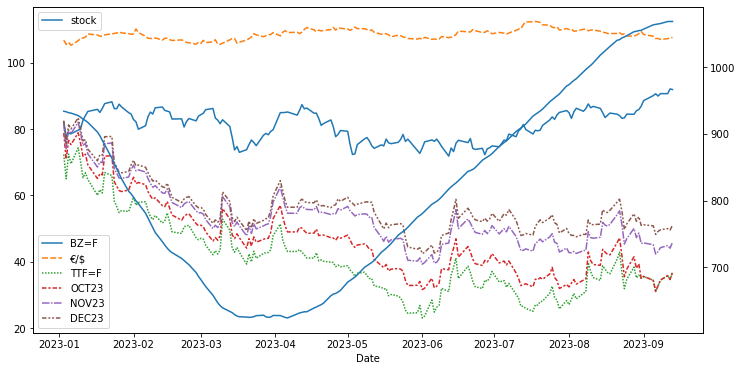

In [75]:
# On fait une copie du DF et on remet les index
# cette copy est filtrée suivant l'année
an = 2023
fin_1 = filtreAnnee(fin,an).copy(deep=True)
fin_2 = filtreAnnee(fin[['gasInStorage','Date','année']],an).copy(deep=True)
fin_1 = fin_1.set_index("Date")
fin_2 = fin_2.set_index("Date")
# On normalise si besoin 
maxi = fin_1["gasInStorage"].max()
print('Stock maxi sur la période : ',maxi)
maxi = 100.0 # si on ne souhaite pas normaliser
# on normalise le stock (100%) et on nettoye ...
fin_2["stock"] = fin_2["gasInStorage"] / maxi * 100.0
# print(fin_1.head())
fin_1['€/$'] = fin_1['€/$'] * 100.0
fin_1 = fin_1.drop(['année','mois','gasDayStart','gasInStorage'], axis=1)
fin_2 = fin_2.drop(['gasInStorage','année'],axis=1)
# on Affiche le graphique
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=fin_1, color='Blue')
ax2 = plt.twinx()
sns.lineplot(data=fin_2, ax=ax2 , color='red')

In [76]:
fin[0:16]

,gasDayStart,gasInStorage,Date,année,mois,BZ=F,€/$,TTF=F,OCT23,NOV23,DEC23
0,2023-09-13,1068.5602,2023-09-13,2023,9,91.879997,1.075327,36.817001,36.817001,45.896999,51.042999
1,2023-09-12,1068.5436,2023-09-12,2023,9,92.059998,1.075038,34.701000,34.701000,44.106998,49.583000
2,2023-09-11,1068.4668,2023-09-11,2023,9,90.639999,1.071811,35.848000,35.848000,44.898998,50.007999
5,2023-09-08,1065.4458,2023-09-08,2023,9,90.650002,1.069782,34.507999,34.507999,44.265999,49.654999
6,2023-09-07,1064.7559,2023-09-07,2023,9,89.919998,1.072420,32.755001,32.755001,43.106998,49.161999
7,2023-09-06,1064.1210,2023-09-06,2023,9,90.599998,1.072616,31.075001,31.075001,42.333000,48.259998
8,2023-09-05,1063.5247,2023-09-05,2023,9,90.040001,1.079447,34.449001,34.449001,45.148998,50.848999
12,2023-09-01,1057.0820,2023-09-01,2023,9,88.550003,1.084410,35.617001,35.617001,45.724998,51.160000
13,2023-08-31,1055.1813,2023-08-31,2023,8,86.860001,1.093255,35.028999,35.028999,45.525002,50.955002
14,2023-08-30,1054.9060,2023-08-30,2023,8,85.860001,1.086921,35.992001,39.377998,48.667999,53.618000


              gasInStorage     TTF=F      BZ=F     OCT23     NOV23     DEC23
gasInStorage      1.000000  0.007930 -0.252261  0.147700  0.158868  0.164997
TTF=F             0.007930  1.000000  0.695727  0.904733  0.896172  0.891850
BZ=F             -0.252261  0.695727  1.000000  0.598985  0.604469  0.605477
OCT23             0.147700  0.904733  0.598985  1.000000  0.998441  0.996711
NOV23             0.158868  0.896172  0.604469  0.998441  1.000000  0.999656
DEC23             0.164997  0.891850  0.605477  0.996711  0.999656  1.000000


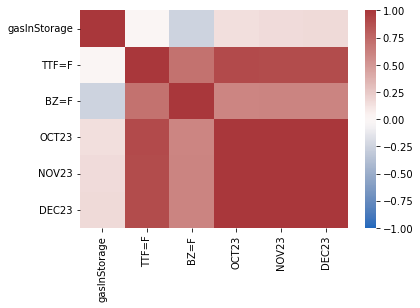

In [78]:
fin_ = fin[["gasInStorage","TTF=F","BZ=F","OCT23","NOV23","DEC23","Date"]]
fin_ = fin_.set_index('Date')
sns.heatmap(fin_.corr(), vmin=-1, vmax=1, cmap='vlag')
print(fin_.corr())